### This notebook uses the data of two full runs of LST-1 (folder "20201118" of "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/" in the PIC). The file "data.csv" has been obtained joining all the .h5 files in 20201118 and applying a cut for: gammaness > 0.8.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from datetime import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import builtin_frames

In [2]:
data = pd.read_csv('data.csv')
data.shape

(3496, 50)

In [3]:
data.columns

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'obs_id', 'event_id',
       'calibration_id', 'dragon_time', 'ucts_time', 'tib_time', 'mc_type',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'ucts_trigger_type', 'trigger_time',
       'log_reco_energy', 'reco_energy', 'reco_disp_dx', 'reco_disp_dy',
       'reco_src_x', 'reco_src_y', 'reco_alt', 'reco_az', 'reco_type',
       'gammaness'],
      dtype='object')

## Calculate the equatorial coordinates (right ascension and declination) of the events + make a skymap of the reconstructed directions of the events in these coordinates

In [4]:
data.head()

,intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,...,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gammaness
0,502.399428,2.701049,0.322315,-0.127583,0.346647,-0.376908,0.316937,0.066858,-0.409438,0.229186,...,-0.497366,0.318151,-0.648855,0.263107,-0.326540,0.135525,1.249384,1.888268,0,0.849500
1,1191.311688,3.076025,0.865038,-0.262193,0.903900,-0.294298,0.310509,0.095809,0.111489,-0.731748,...,-0.289115,0.513908,0.641334,0.081768,1.506372,-0.180425,1.314818,1.847555,0,0.833452
2,1246.988173,3.095862,0.414243,0.416859,0.587680,0.788545,0.235116,0.068514,-0.014026,-0.525790,...,-0.736966,0.183246,0.372461,-0.015322,0.786704,0.401537,1.288863,1.924547,0,0.856167
3,588.691348,2.769888,-0.174841,0.662240,0.684931,1.828922,0.320345,0.089777,0.563453,0.143456,...,-0.326762,0.471236,-0.672341,-0.426305,-0.847183,0.235935,1.230772,1.898274,0,0.852833
4,424.203515,2.627574,-0.353369,0.167959,0.391254,2.697895,0.488380,0.079805,-1.028104,0.051173,...,0.101661,1.263751,-0.699044,1.192163,-1.052413,1.360122,1.220266,2.014804,0,0.891167


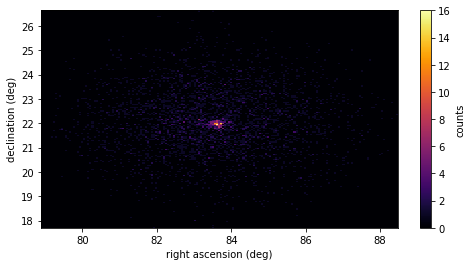

In [5]:
utc_time = []
for i in range(data.shape[0]):
    a = datetime.utcfromtimestamp(data['dragon_time'][i])
    utc_time.append(a)
    
data['utc_time'] = utc_time   #add new column to the data frame with the UTC observation times of the events

loc = EarthLocation(lat = 28.76138889*u.deg, lon = -17.89138889*u.deg, height = 2184*u.m)   #location of the telescope (CTA LST1: Roque de los Muchachos)

hor_coords = SkyCoord(alt = data['reco_alt'], az = data['reco_az'], frame = 'altaz', unit = 'rad', 
                      obstime = data['utc_time'], location = loc)   #horizontal coordinates of the events
eq_coords = hor_coords.icrs   #equatorial coordinates of the events

data['RA'] = eq_coords.ra    #add columns with right ascension and declination (equatorial coordinates) of the events
data['DEC'] = eq_coords.dec

# skymap (RA, dec) de las posiciones reconstruidas de los sucesos (ya se ha aplicado el corte de gammaness > 0.8):
plt.figure(figsize=(8,4))
h = plt.hist2d(data['RA'], data['DEC'], bins = 175, cmap = 'inferno')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)')
plt.colorbar(label='counts')

## Ver que hay un exceso significativo de sucesos (gammas) en las coordenadas del Crab y estimar el número de gammas (haciendo "aperture photometry"). 

In [20]:
data1 = data.loc[(data['intensity']>200)]
data1.shape

(3249, 59)

<ipython-input-28-b7193d1ff3c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['theta²'] = (eq_coords.separation(crab))**2  #square of the angular separation between the events and the crab (in deg)
<ipython-input-28-b7193d1ff3c2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['RA_tel'] = eq_coords_tel.ra    #add new columns with the pointing direction of the telescope at each moment in equatorial coordinates (ra and dec)
<ipython-input-28-b7193d1ff3c2>:11: SettingWithCopyWarning: 
A value 

Excess of gamma rays: 210.0


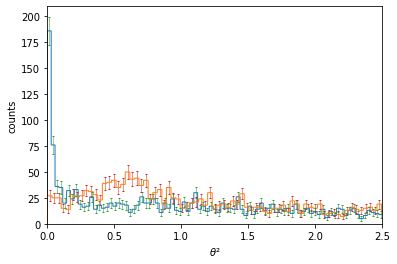

In [28]:
crab = SkyCoord.from_name('M1')    #equatorial coordinates of the Crab nebula in deg

eq_coords = SkyCoord(data1['RA'], data1['DEC'], frame='icrs', unit='deg')   #frame 'icrs' = equatorial coordinates (of the events)
data1['theta²'] = (eq_coords.separation(crab))**2  #square of the angular separation between the events and the crab (in deg)

hor_coords_tel = SkyCoord(alt = data1['alt_tel'], az = data1['az_tel'], frame = 'altaz', unit = 'rad', 
                      obstime = data1['utc_time'], location = loc)   #horizontal coordinates of the telescope
eq_coords_tel = hor_coords_tel.icrs   #equatorial coordinates of the telescope

data1['RA_tel'] = eq_coords_tel.ra    #add new columns with the pointing direction of the telescope at each moment in equatorial coordinates (ra and dec)
data1['DEC_tel'] = eq_coords_tel.dec  

skyoffset_frame = builtin_frames.SkyOffsetFrame(origin = eq_coords_tel)  #define a new reference frame centered at the pointing direction of the telescope at each moment

crab2 = crab.transform_to(skyoffset_frame)   #position of the Crab nebula with respect to the new frame 

sym_pos = SkyCoord(-crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg')  #symmetric position to the position of the Crab with respect to the center of the FOV
sym_pos = sym_pos.transform_to('icrs') 

data1['theta²_2'] = (eq_coords.separation(sym_pos))**2 #square of the angular separation between the events and the symmetric position to the crab with respect to the center of the FOV (in deg)

plt.figure()
(n1, b1, p1) = plt.hist(data1['theta²'], bins=750, histtype = 'step')
(n2, b2, p2) = plt.hist(data1['theta²_2'], bins=750, histtype = 'step')
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  #the bin contents are described by poissonian distributions, so the the error (std) is given by sqrt(n)
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.xlabel(r'$\theta²$')
plt.ylabel('counts')
plt.xlim(0,2.5)
plt.savefig('theta2.png')

excess_gammas = n1[0]+n1[1]-n2[0]-n2[1]
print('Excess of gamma rays: {}'. format(excess_gammas))

## Do the same, but instead of taking only one off zone, take three (añadir 2 más en forma de cruz para tener más estadística para calcular el fondo).

<ipython-input-30-c663afab262b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['theta²'] = (eq_coords.separation(crab))**2  #square of the angular separation between the events and the crab (in deg)
<ipython-input-30-c663afab262b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['RA_tel'] = eq_coords_tel.ra    #add new columns with the pointing direction of the telescope at each moment in equatorial coordinates (ra and dec)
<ipython-input-30-c663afab262b>:11: SettingWithCopyWarning: 
A value 

Excess of gamma rays: 209.33333333333331


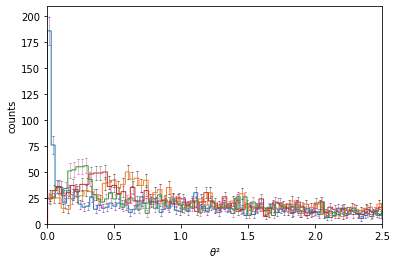

In [30]:
crab = SkyCoord.from_name('M1')    #equatorial coordinates of the Crab nebula in deg

eq_coords = SkyCoord(data1['RA'], data1['DEC'], frame='icrs', unit='deg')   #frame 'icrs' = equatorial coordinates (of the events)
data1['theta²'] = (eq_coords.separation(crab))**2  #square of the angular separation between the events and the crab (in deg)

hor_coords_tel = SkyCoord(alt = data1['alt_tel'], az = data1['az_tel'], frame = 'altaz', unit = 'rad', 
                      obstime = data1['utc_time'], location = loc)   #horizontal coordinates of the telescope
eq_coords_tel = hor_coords_tel.icrs   #equatorial coordinates of the telescope

data1['RA_tel'] = eq_coords_tel.ra    #add new columns with the pointing direction of the telescope at each moment in equatorial coordinates (ra and dec)
data1['DEC_tel'] = eq_coords_tel.dec  

skyoffset_frame = builtin_frames.SkyOffsetFrame(origin = eq_coords_tel)  #define a new reference frame centered at the pointing direction of the telescope at each moment

crab2 = crab.transform_to(skyoffset_frame)   #position of the Crab nebula with respect to the new frame 

pos1 = SkyCoord(-crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg')  #symmetric position to the position of the Crab with respect to the center of the FOV
pos2 = SkyCoord(crab2.lon, -crab2.lat, frame = skyoffset_frame, unit = 'deg') 
pos3 = SkyCoord(-crab2.lon, crab2.lat, frame = skyoffset_frame, unit = 'deg') 
pos1 = pos1.transform_to('icrs') 
pos2 = pos2.transform_to('icrs')
pos3 = pos3.transform_to('icrs')

data1['theta²_2'] = (eq_coords.separation(pos1))**2 
data1['theta²_3'] = (eq_coords.separation(pos2))**2 
data1['theta²_4'] = (eq_coords.separation(pos3))**2

plt.figure()
(n1, b1, p1) = plt.hist(data1['theta²'], bins=750, histtype = 'step')
(n2, b2, p2) = plt.hist(data1['theta²_2'], bins=750, histtype = 'step')
(n3, b3, p3) = plt.hist(data1['theta²_3'], bins=750, histtype = 'step')
(n4, b4, p4) = plt.hist(data1['theta²_4'], bins=750, histtype = 'step')
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.errorbar((b3[1:]+b3[:-1])/2, n3, fmt = 'none' , yerr=np.sqrt(n3), elinewidth=0.5, capsize=1) 
plt.errorbar((b4[1:]+b4[:-1])/2, n4, fmt = 'none' , yerr=np.sqrt(n4), elinewidth=0.5, capsize=1)
plt.xlabel(r'$\theta²$')
plt.ylabel('counts')
plt.xlim(0, 2.5)
plt.savefig('theta2_2.png')

excess_gammas = n1[0]+n1[1]-np.mean([n2[0],n3[0],n4[0]])-np.mean([n2[1],n3[1],n4[1]])
print('Excess of gamma rays: {}'. format(excess_gammas))

## Obtain the distribution of theta², width, length and intensity of (only) the gamma rays.

#### *** ERROR PROPAGATION: 

($n_1$, $n_2$, $n_3$, $n_4$): histogram bins (for each position) 

($\sqrt{n_1}$, $\sqrt{n_2}$, $\sqrt{n_3}$, $\sqrt{n_4}$): errors of each "variable" ($n_i$)

new variable (function of $(n_1, n_2, n_3, n_4)$): $n(n_1, n_2, n_3, n_4)=n_1-\frac{1}{3}(n_2+n_3+n_4)$

Covariance matrix of the variables $n_i$ (since $\sigma_i=\sqrt{n_i}$ and $cov(x_i,x_i)=\sigma_i²$): 

\begin{equation*}
V = cov[n_i,n_j]=
\begin{pmatrix}
n_1 &  &  & \\
& n_2 &  & \\
 &  & n_3 &  \\
 &  &  &  n_4
\end{pmatrix}
\end{equation*}

To obtain the variance $U$ of the variable $n$, we use error propagation: 
$$U = \sum_{k,l=1}^n \frac{\partial n}{\partial n_i} \frac{\partial n}{\partial n_j} V_{kl}$$
$$A_1 = \frac{\partial n}{\partial n_1}=1  ; \quad A_2=A_3=A_4=-1/3 \quad \Rightarrow U=V_{11}+\frac{1}{9}(V_{22}+V_{33}+V_{44})$$

In [31]:
gammas = data1[(data1['theta²']<0.5)]
bkg2 = data1[(data1['theta²_2']<0.5)]
bkg3 = data1[(data1['theta²_3']<0.5)]
bkg4 = data1[(data1['theta²_4']<0.5)]

Text(0, 0.5, 'counts')

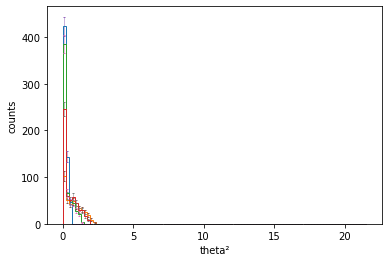

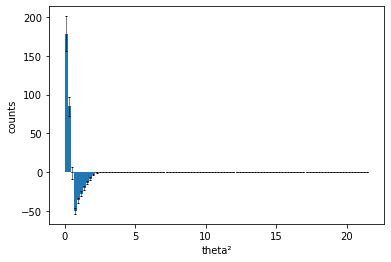

In [32]:
# distribution of theta² of the gamma rays

a = min(data1['theta²'])
b = max(data1['theta²'])
plt.figure()
(n1,b1,p1) = plt.hist(gammas['theta²'], histtype = 'step', bins = 100, range = (a,b))
(n2,b2,p2) = plt.hist(bkg2['theta²'], histtype = 'step', bins = 100, range = (a,b))
(n3,b3,p3) = plt.hist(bkg3['theta²'], histtype = 'step', bins = 100, range = (a,b))
(n4,b4,p4) = plt.hist(bkg4['theta²'], histtype = 'step', bins = 100, range = (a,b))
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.errorbar((b3[1:]+b3[:-1])/2, n3, fmt = 'none' , yerr=np.sqrt(n3), elinewidth=0.5, capsize=1) 
plt.errorbar((b4[1:]+b4[:-1])/2, n4, fmt = 'none' , yerr=np.sqrt(n4), elinewidth=0.5, capsize=1)
plt.xlabel('theta²')
plt.ylabel('counts')

n = n1-(1/3)*(n2+n3+n4)
err_n = np.sqrt(n1+1/9*(n2+n3+n4))  #error of n, obtained by error propagation 
#for i in range(len(n)): 
 #   if n[i]<0:
  #      n[i]=0

width = b1[1] - b1[0]
plt.figure()
plt.bar(b1[:-1], n, align='edge', width=width)
plt.errorbar((b1[1:]+b1[:-1])/2, n, fmt = 'none', ecolor='k', yerr=err_n, elinewidth=0.5, capsize=1)
plt.xlabel('theta²')
plt.ylabel('counts')
#plt.xlim(0,2.5)

/home/maria/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/maria/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'intensity')

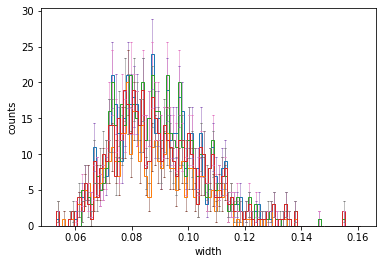

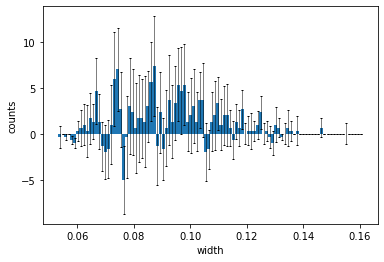

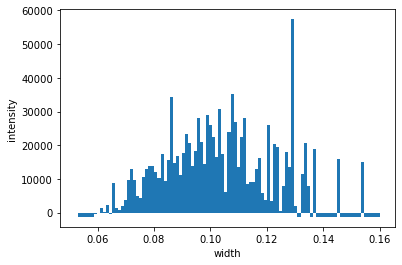

In [33]:
# distribution of the width of the cascades initiated by gamma rays

a = min(data1['width'])
b = max(data1['width'])
plt.figure()
(n1,b1,p1) = plt.hist(gammas['width'], histtype = 'step', bins = 100, range = (a,b))
(n2,b2,p2) = plt.hist(bkg2['width'], histtype = 'step', bins = 100, range = (a,b))
(n3,b3,p3) = plt.hist(bkg3['width'], histtype = 'step', bins = 100, range = (a,b))
(n4,b4,p4) = plt.hist(bkg4['width'], histtype = 'step', bins = 100, range = (a,b))
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.errorbar((b3[1:]+b3[:-1])/2, n3, fmt = 'none' , yerr=np.sqrt(n3), elinewidth=0.5, capsize=1) 
plt.errorbar((b4[1:]+b4[:-1])/2, n4, fmt = 'none' , yerr=np.sqrt(n4), elinewidth=0.5, capsize=1)
plt.xlabel('width')
plt.ylabel('counts')

n = n1-(1/3)*(n2+n3+n4)
err_n = np.sqrt(n1+1/9*(n2+n3+n4))  #error of n, obtained by error propagation

width = b1[1] - b1[0]
plt.figure()
plt.bar(b1[:-1], n, align='edge', width=width)
plt.errorbar((b1[1:]+b1[:-1])/2, n, fmt = 'none', ecolor='k', yerr=err_n, elinewidth=0.5, capsize=1)
plt.xlabel('width')
plt.ylabel('counts')


#plot de 'width' en bins de intensity: 

df1 = gammas[(gammas['width']>=b1[0]) & (gammas['width']<=b1[1])]
df2 = bkg2[(bkg2['width']>=b1[0]) & (bkg2['width']<=b1[1])]
df3 = bkg3[(bkg3['width']>=b1[0]) & (bkg3['width']<=b1[1])]
df4 = bkg4[(bkg4['width']>=b1[0]) & (bkg4['width']<=b1[1])]
n2 = [df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                          df4.sum(axis=0)['intensity'])]    #intensity
for i in range(1,len(b1)-1):
    df1 = gammas[(gammas['width']>b1[i]) & (gammas['width']<=b1[i+1])]
    n1 = [df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                          df4.sum(axis=0)['intensity'])]    #intensity
    n2.append(n1)

plt.figure()
plt.bar(b1[:-1], n2, align='edge', width=b1[0]-b1[1])
plt.xlabel('width')
plt.ylabel('intensity')

/home/maria/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/maria/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'intensity')

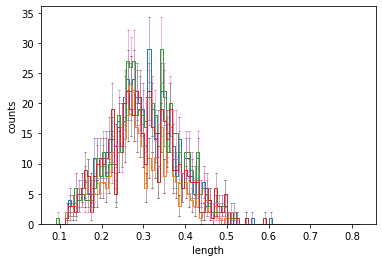

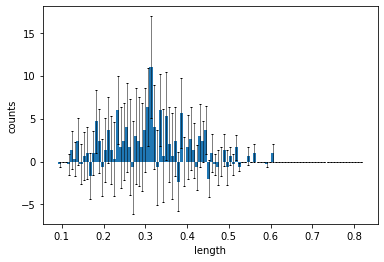

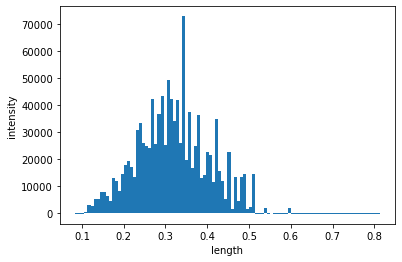

In [36]:
# distribution of the length of the cascades initiated by gamma rays

a = min(data1['length'])
b = max(data1['length'])
plt.figure()
(n1,b1,p1) = plt.hist(gammas['length'], histtype = 'step', bins = 100, range = (a,b))
(n2,b2,p2) = plt.hist(bkg2['length'], histtype = 'step', bins = 100, range = (a,b))
(n3,b3,p3) = plt.hist(bkg3['length'], histtype = 'step', bins = 100, range = (a,b))
(n4,b4,p4) = plt.hist(bkg4['length'], histtype = 'step', bins = 100, range = (a,b))
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.errorbar((b3[1:]+b3[:-1])/2, n3, fmt = 'none' , yerr=np.sqrt(n3), elinewidth=0.5, capsize=1) 
plt.errorbar((b4[1:]+b4[:-1])/2, n4, fmt = 'none' , yerr=np.sqrt(n4), elinewidth=0.5, capsize=1)
plt.xlabel('length')
plt.ylabel('counts')

n = n1-(1/3)*(n2+n3+n4)
err_n = np.sqrt(n1+1/9*(n2+n3+n4))  #error of n, obtained by error propagation

width = b1[1] - b1[0]
plt.figure()
plt.bar(b1[:-1], n, align='edge', width=width)
plt.errorbar((b1[1:]+b1[:-1])/2, n, fmt = 'none', ecolor='k', yerr=err_n, elinewidth=0.5, capsize=1)
plt.xlabel('length')
plt.ylabel('counts')

#plot de 'length' en bins de intensity: 

df1 = gammas[(gammas['length']>=b1[0]) & (gammas['length']<=b1[1])]
df2 = bkg2[(bkg2['length']>=b1[0]) & (bkg2['length']<=b1[1])]
df3 = bkg3[(bkg3['length']>=b1[0]) & (bkg3['length']<=b1[1])]
df4 = bkg4[(bkg4['length']>=b1[0]) & (bkg4['length']<=b1[1])]
n2 = [df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                          df4.sum(axis=0)['intensity'])]    #intensity
for i in range(1,len(b1)-1):
    df1 = gammas[(gammas['length']>b1[i]) & (gammas['length']<=b1[i+1])]
    n1 = [df1.sum(axis=0)['intensity']-(1/3)*(df2.sum(axis=0)['intensity']+df3.sum(axis=0)['intensity']+
                                          df4.sum(axis=0)['intensity'])]    #intensity
    n2.append(n1)

plt.figure()
plt.bar(b1[:-1], n2, align='edge', width=b1[0]-b1[1])
plt.xlabel('length')
plt.ylabel('intensity')

Text(0, 0.5, 'counts')

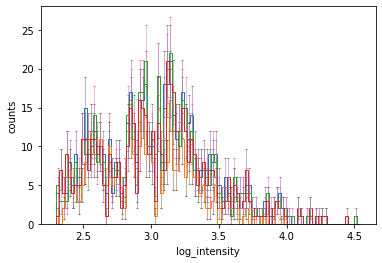

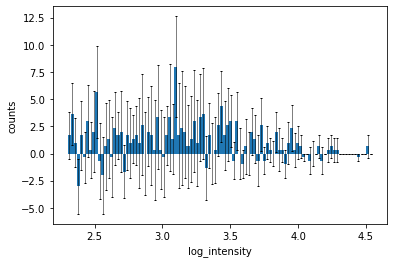

In [35]:
# distribution of log_intensity of the cascades initiated by gamma rays

a = min(data1['log_intensity'])
b = max(data1['log_intensity'])
plt.figure()
(n1,b1,p1) = plt.hist(gammas['log_intensity'], histtype = 'step', bins = 100, range = (a,b))
(n2,b2,p2) = plt.hist(bkg2['log_intensity'], histtype = 'step', bins = 100, range = (a,b))
(n3,b3,p3) = plt.hist(bkg3['log_intensity'], histtype = 'step', bins = 100, range = (a,b))
(n4,b4,p4) = plt.hist(bkg4['log_intensity'], histtype = 'step', bins = 100, range = (a,b))
plt.errorbar((b1[1:]+b1[:-1])/2, n1, fmt = 'none' , yerr=np.sqrt(n1), elinewidth=0.5, capsize=1)  
plt.errorbar((b2[1:]+b2[:-1])/2, n2, fmt = 'none' , yerr=np.sqrt(n2), elinewidth=0.5, capsize=1)
plt.errorbar((b3[1:]+b3[:-1])/2, n3, fmt = 'none' , yerr=np.sqrt(n3), elinewidth=0.5, capsize=1) 
plt.errorbar((b4[1:]+b4[:-1])/2, n4, fmt = 'none' , yerr=np.sqrt(n4), elinewidth=0.5, capsize=1)
plt.xlabel('log_intensity')
plt.ylabel('counts')

n = n1-(1/3)*(n2+n3+n4)
err_n = np.sqrt(n1+1/9*(n2+n3+n4))  #error of n, obtained by error propagation

width = b1[1] - b1[0]
plt.figure()
plt.bar(b1[:-1], n, align='edge', width=width)
plt.errorbar((b1[1:]+b1[:-1])/2, n, fmt = 'none', ecolor='k', yerr=err_n, elinewidth=0.5, capsize=1)
plt.xlabel('log_intensity')
plt.ylabel('counts')